Ссылка на блокнотик - https://colab.research.google.com/drive/1gHxEoOnNaDlhxljG-s8xF5RpyXm9ilFx?usp=sharing

In [ ]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn as sk

from sklearn.base             import BaseEstimator, ClassifierMixin, clone
from sklearn.tree             import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble         import BaggingClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets         import make_classification, make_regression
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils            import resample, check_random_state

from catboost import CatBoostClassifier, Pool

import optuna

In [ ]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Данные

In [ ]:
data.dtypes

,0
id,int64
age,float64
height(cm),float64
weight(kg),float64
waist(cm),float64
eyesight(left),float64
eyesight(right),float64
hearing(left),float64
hearing(right),float64
systolic,float64


Все признаки имеют числовой вид

In [ ]:
def build_distribution(values, column):
  sns.kdeplot(values, fill=True, cut=0)
  plt.plot([values.mean(), values.mean()], [0, np.max(plt.yticks()[0])], label='Средее')
  plt.scatter([], [], alpha=0, label=f'Асимметрия: {scipy.stats.skew(values):.3f}')
  plt.scatter([], [], alpha=0, label=f'Эксцесс: {scipy.stats.kurtosis(values):.3f}')
  plt.title(f'Плотность {column}')
  plt.legend()

def show_distribution(df, column):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[column], column)
  plt.subplot(1, 2, 2)
  plt.boxplot(df[column], tick_labels=[column])
  plt.title(f'Размах {column}')
  plt.show()

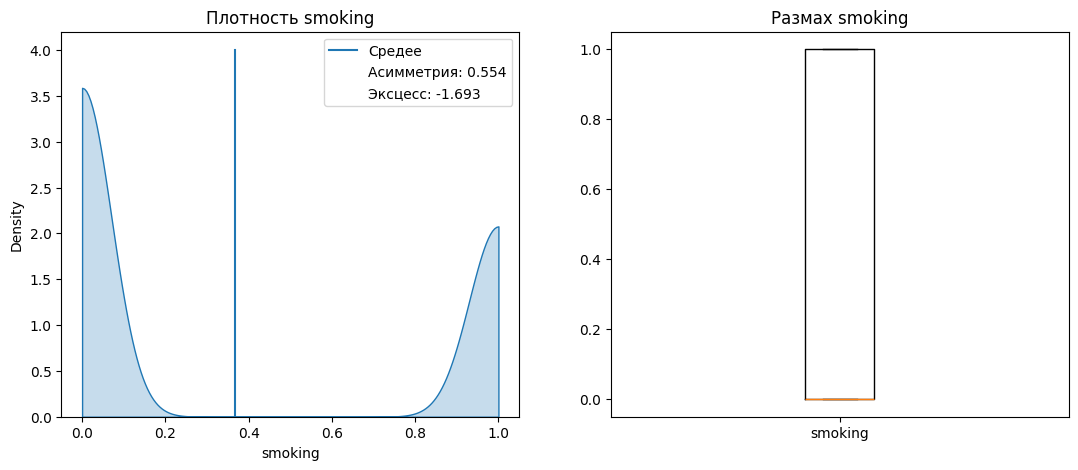

In [ ]:
show_distribution(data, 'smoking')

Выбросов нет(?)

In [ ]:
def correlation_matrix(df, figsize=(10, 8), annot=False, title='Correlation Matrix'):
    corr_matrix = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=annot,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

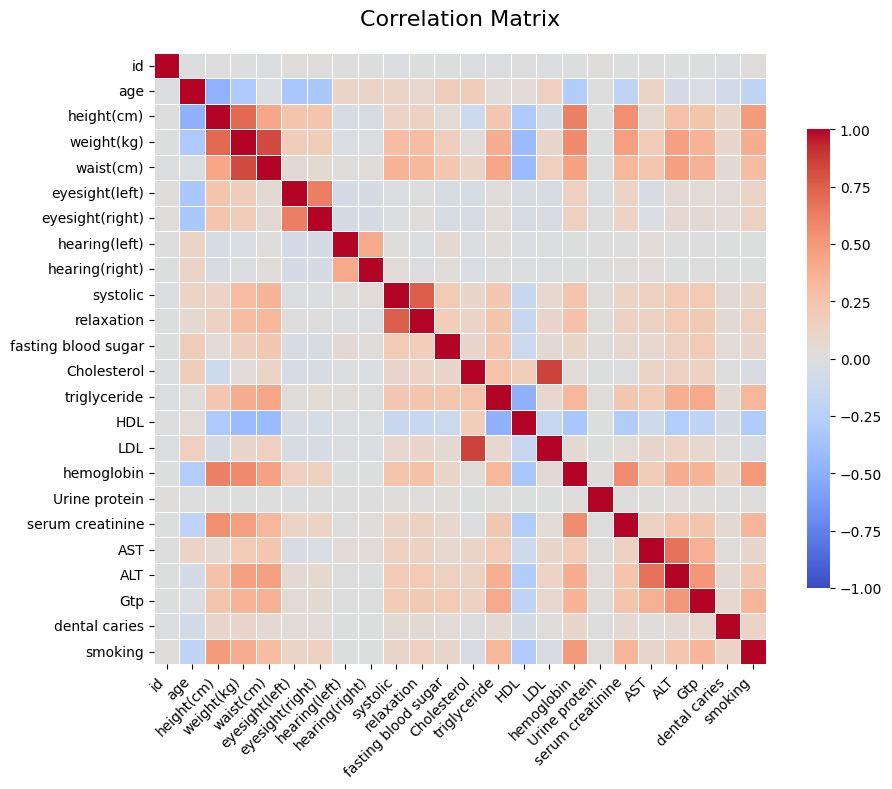

,0
id,int64
age,float64
height(cm),float64
weight(kg),float64
waist(cm),float64
eyesight(left),float64
eyesight(right),float64
hearing(left),float64
hearing(right),float64
systolic,float64


In [ ]:
correlation_matrix(data)
data.dtypes

In [ ]:
def _get_correlation_strength(value):
    if value < 0.2:
        return "очень слабая"
    elif 0.2 <= value < 0.4:
        return "слабая"
    elif 0.4 <= value < 0.6:
        return "умеренная"
    elif 0.6 <= value < 0.8:
        return "сильная"
    else:
        return "очень сильная"

def dependency(df, x_col, y_col, figsize=(10, 6), title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=figsize)

    xlabel = xlabel or x_col
    ylabel = ylabel or y_col

    sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

    corr_coef = np.corrcoef(df[x_col], df[y_col])[0, 1]

    corr_text = (f"Коэффициент корреляции (r): {corr_coef:.3f}\n"
                 f"Сила корреляции: {_get_correlation_strength(abs(corr_coef))}")

    plt.annotate(corr_text, xy=(0.05, 0.85), xycoords='axes fraction',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10)

    plt.title(title or f'Зависимость {y_col} от {x_col}', fontsize=14, pad=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

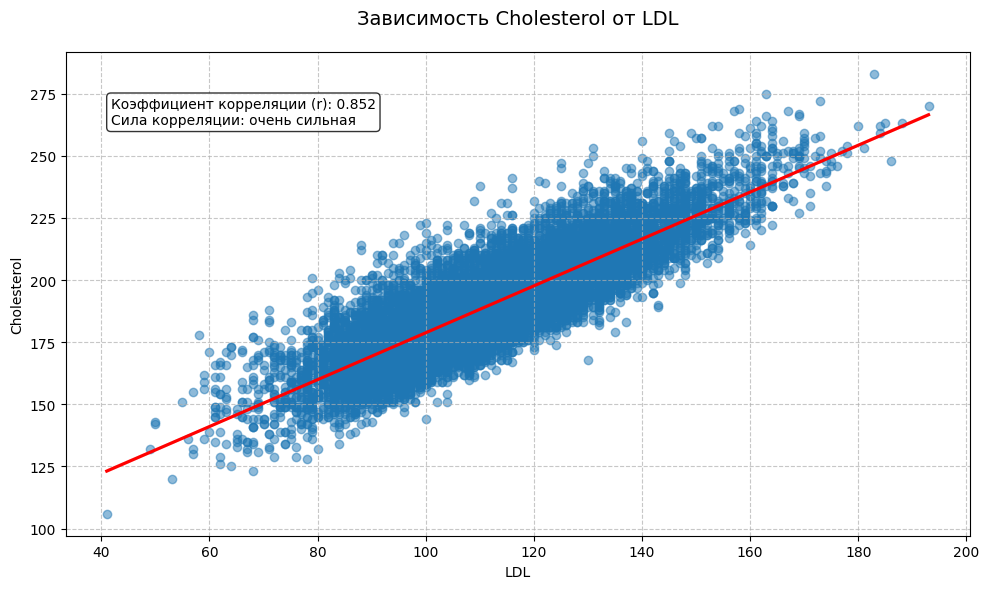

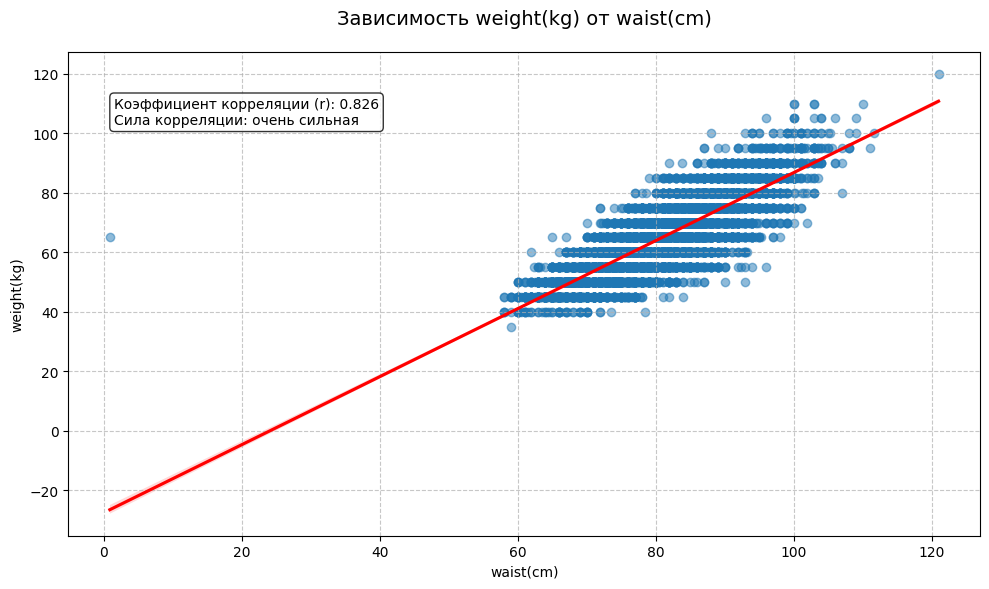

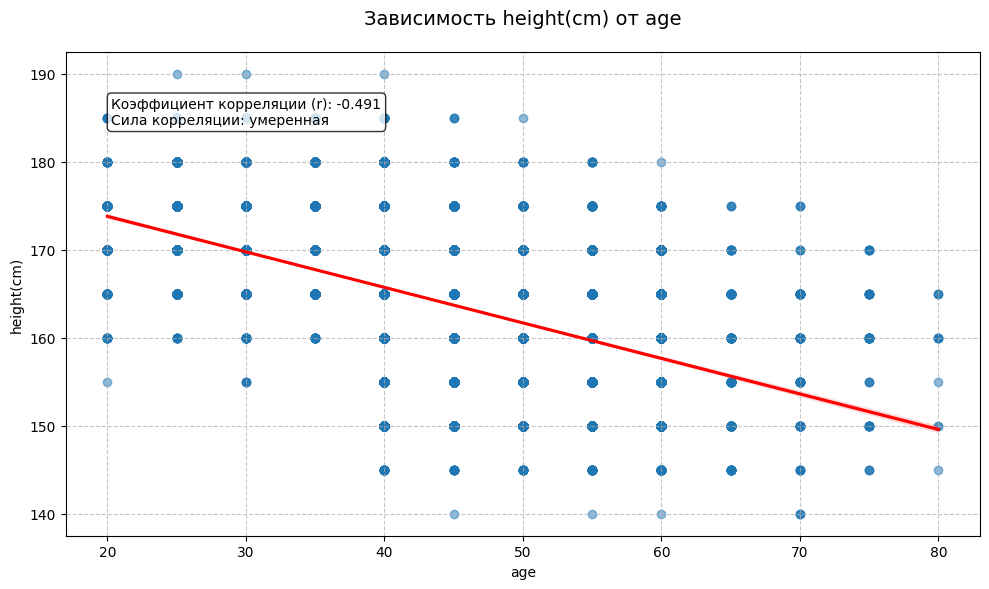

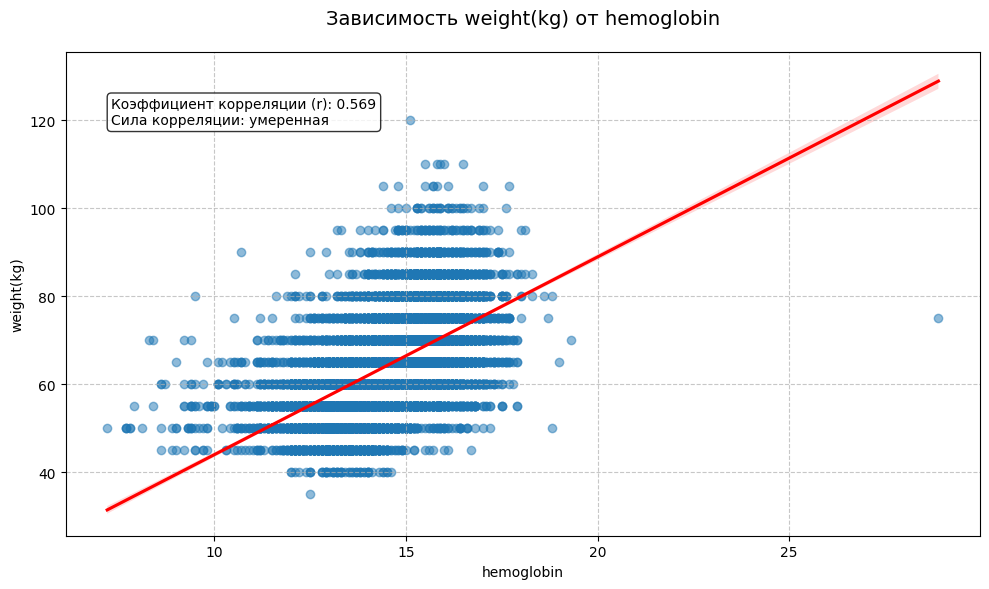

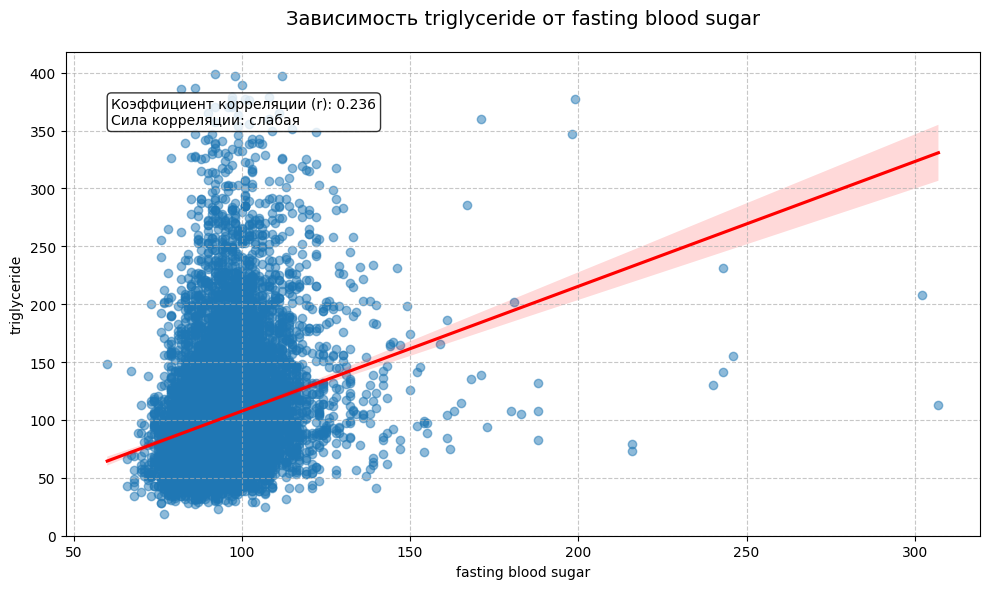

In [ ]:
dependency(data, 'LDL', 'Cholesterol')
dependency(data, 'waist(cm)', 'weight(kg)')
dependency(data, 'age', 'height(cm)')
dependency(data, 'hemoglobin', 'weight(kg)')
dependency(data, 'fasting blood sugar', 'triglyceride')

# Bagging Regression

In [ ]:
class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.estimators_ = []

        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y, random_state=np.random.randint(1e9))

            estimator = clone(self.base_estimator)
            estimator.fit(X_sample, y_sample)

            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)

    def predict_proba(self, X):
        probas = [estimator.predict_proba(X) for estimator in self.estimators_]
        return np.mean(probas, axis=0)

In [ ]:
X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop('id', axis=1)

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=4)
my_bagging = MyBaggingClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
my_bagging.fit(X_train, y_train)
my_pred = my_bagging.predict_proba(X_val)[:, 1]

sklearn_bagging = BaggingClassifier(base_estimator, n_estimators=50, random_state=42)
sklearn_bagging.fit(X_train, y_train)
sklearn_pred = sklearn_bagging.predict_proba(X_val)[:, 1]

print(f"My ROC-AUC:\t\t {roc_auc_score(y_val, my_pred)}")
print(f"Sklearn ROC-AUC:\t {roc_auc_score(y_val, sklearn_pred)}")

My ROC-AUC:		 0.8654848141860028
Sklearn ROC-AUC:	 0.8654951895868703


# Gradient Boosting

In [ ]:
class MyGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        self.models = []
        self.init_val = np.log(np.mean(y) / (1 - np.mean(y)))
        self.F = np.full(y.shape, self.init_val)

        rng = check_random_state(self.random_state)

        for i in range(self.n_estimators):
            p = self._sigmoid(self.F)
            residual = y - p
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=rng.randint(0, 10000))
            tree.fit(X, residual)
            update = tree.predict(X)
            self.F += self.learning_rate * update
            self.models.append(tree)

    def decision_function(self, X):
        F = np.full((X.shape[0],), self.init_val)
        for tree in self.models:
            F += self.learning_rate * tree.predict(X)
        return F

    def predict_proba(self, X):
        F = self.decision_function(X)
        prob_1 = self._sigmoid(F)
        return np.vstack([1 - prob_1, prob_1]).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


In [ ]:
X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop('id', axis=1)

In [ ]:
my_gb = MyGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
my_gb.fit(X_train, y_train)
my_pred = my_gb.predict_proba(X_val)[:, 1]

sklearn_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                      max_depth=4, random_state=42)
sklearn_gb.fit(X_train, y_train)
sklearn_pred = sklearn_gb.predict_proba(X_val)[:, 1]

print(f"\nMy ROC-AUC:\t\t {roc_auc_score(y_val, my_pred)}")
print(f"Sklearn ROC-AUC:\t {roc_auc_score(y_val, sklearn_pred)}")


My ROC-AUC:		 0.8762535370684776
Sklearn ROC-AUC:	 0.890502735332956


# Сравнение реализаций

In [ ]:
X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop('id', axis=1)

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
def compare_boosters(X_train, y_train, X_val, y_val):
    models = {
        "My GB": MyGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42),
        "Sklearn GB": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, pred)
        results.append((name, auc))
        print(f"{name}: ROC-AUC = {auc:.4f}")

    return max(results, key=lambda x: x[1])

best_model_name, best_auc = compare_boosters(X_train, y_train, X_val, y_val)
print(f"\nThe best model: {best_model_name} с ROC-AUC = {best_auc:.4f}")

My GB: ROC-AUC = 0.8763
Sklearn GB: ROC-AUC = 0.8898
XGBoost: ROC-AUC = 0.8813
LightGBM: ROC-AUC = 0.8911
CatBoost: ROC-AUC = 0.8921

The best model: CatBoost с ROC-AUC = 0.8921


Лучший результат за CatBoost

# Подбор гиперпараметров

In [ ]:
X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop('id', axis=1)

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
    }

    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

# Оптимизация
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best AUC: ", study.best_value)
print("Best hyperparameters: ", study.best_params)


[I 2025-05-23 20:31:00,308] A new study created in memory with name: no-name-e4958559-2ab3-4df2-803b-3b0906e49d8e
[I 2025-05-23 20:31:15,195] Trial 0 finished with value: 0.8928485191473308 and parameters: {'iterations': 1874, 'depth': 6, 'learning_rate': 0.008496797853838325}. Best is trial 0 with value: 0.8928485191473308.
[I 2025-05-23 20:33:07,563] Trial 1 finished with value: 0.8889841539332201 and parameters: {'iterations': 1469, 'depth': 11, 'learning_rate': 0.017494522570874534}. Best is trial 0 with value: 0.8928485191473308.
[I 2025-05-23 20:35:22,815] Trial 2 finished with value: 0.8857956046029052 and parameters: {'iterations': 2932, 'depth': 10, 'learning_rate': 0.04504865494786901}. Best is trial 0 with value: 0.8928485191473308.
[I 2025-05-23 20:36:45,365] Trial 3 finished with value: 0.8824924542539143 and parameters: {'iterations': 2726, 'depth': 9, 'learning_rate': 0.09579995279245412}. Best is trial 0 with value: 0.8928485191473308.
[I 2025-05-23 20:40:08,836] Trial 

Best AUC:  0.893869081305414
Best hyperparameters:  {'iterations': 1404, 'depth': 7, 'learning_rate': 0.008082123092542423}


Best AUC:  0.893869081305414

---
Best hyperparameters:  {'iterations': 1404, 'depth': 7, 'learning_rate': 0.008082123092542423}

# Метрики

In [ ]:
def accuracy_score_custom(y_true, y_pred):
    correct = (y_true == y_pred).sum()
    total = len(y_true)
    return correct / total

def precision_score_custom(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall_score_custom(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_score_custom(y_true, y_pred):
    prec = precision_score_custom(y_true, y_pred)
    rec = recall_score_custom(y_true, y_pred)
    return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

Сравнение на синтетике

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_sk = accuracy_score(y_test, y_pred)
prec_sk = precision_score(y_test, y_pred)
rec_sk = recall_score(y_test, y_pred)
f1_sk = f1_score(y_test, y_pred)

acc_custom = accuracy_score_custom(y_test, y_pred)
prec_custom = precision_score_custom(y_test, y_pred)
rec_custom = recall_score_custom(y_test, y_pred)
f1_custom = f1_score_custom(y_test, y_pred)

print(f"Accuracy  (custom): {acc_custom:.4f} | Sklearn: {acc_sk:.4f}")
print(f"Precision (custom): {prec_custom:.4f} | Sklearn: {prec_sk:.4f}")
print(f"Recall    (custom): {rec_custom:.4f} | Sklearn: {rec_sk:.4f}")
print(f"F1-Score  (custom): {f1_custom:.4f} | Sklearn: {f1_sk:.4f}")


Accuracy  (custom): 0.9100 | Sklearn: 0.9100
Precision (custom): 0.9684 | Sklearn: 0.9684
Recall    (custom): 0.8598 | Sklearn: 0.8598
F1-Score  (custom): 0.9109 | Sklearn: 0.9109


In [ ]:
def auc_roc_score_custom(y_true, y_scores):
    desc_sort = np.argsort(-y_scores)
    y_true = np.array(y_true)[desc_sort]
    y_scores = np.array(y_scores)[desc_sort]

    tp = 0
    fp = 0
    tps = []
    fps = []

    P = sum(y_true)
    N = len(y_true) - P

    for label in y_true:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tps.append(tp)
        fps.append(fp)

    tpr = [t / P for t in tps]
    fpr = [f / N for f in fps]

    auc = 0.0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2
    return auc

def auc_pr_score_custom(y_true, y_scores):
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)
    desc_sort = np.argsort(-y_scores)
    y_true = y_true[desc_sort]

    tp = 0
    fp = 0
    precisions = []
    recalls = []

    total_positives = y_true.sum()
    if total_positives == 0:
        return 0.0

    for i, label in enumerate(y_true):
        if label == 1:
            tp += 1
        else:
            fp += 1
        precision = tp / (tp + fp)
        recall = tp / total_positives
        precisions.append(precision)
        recalls.append(recall)

    ap = 0.0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            ap += precisions[i]
    ap /= total_positives
    return ap

Тестики на синтестике пуфуффкфкк


In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, weights=[0.7], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:, 1]

roc_auc_c = auc_roc_score_custom(y_test, y_scores)
pr_auc_c = auc_pr_score_custom(y_test, y_scores)

roc_auc_sk = roc_auc_score(y_test, y_scores)
pr_auc_sk = average_precision_score(y_test, y_scores)

print(f"AUC-ROC (custom): {roc_auc_c:.4f} | Sklearn: {roc_auc_sk:.4f}")
print(f"AUC-PR  (custom): {pr_auc_c:.4f} | Sklearn: {pr_auc_sk:.4f}")

AUC-ROC (custom): 0.9707 | Sklearn: 0.9707
AUC-PR  (custom): 0.9695 | Sklearn: 0.9695


# Результат

In [ ]:
X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop('id', axis=1)

model = CatBoostClassifier(n_estimators=1359, max_depth=8, learning_rate=0.007689944845816633, verbose=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

df = np.array([test_data['id'], y_pred_proba]).transpose()
res = pd.DataFrame(data=df, columns=['id', 'smoking'])
res.to_csv('result.csv', index=False)